In [11]:
import tensorflow as tf
import numpy as np
import emnist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from IPython.display import display, Image
from PIL import Image, ImageFilter

import numpy

subset = [0,1,2,3,4,5,6,7,8,9]          # 0-9, x, X        
#subset = [0,1,2,3,4,5,6,7,8,9, 33, 59]          # 0-9, x, X
#subset = [2,3,6,7,9]
#subset = [18, 20, 27, 44, 46, 53]       # r,i,k,R,I,

mnist = emnist.read_data_sets('data/emnist', subset = subset)
#print mnist.train.images.shape       # r,i,k,R,I



Extracting data/emnist/emnist-byclass-train-images-idx3-ubyte.gz
Numer of images:697932
Number of rows and cols: 28, 28
Extracting data/emnist/emnist-byclass-train-labels-idx1-ubyte.gz
Extracting data/emnist/emnist-byclass-test-images-idx3-ubyte.gz
Numer of images:116323
Number of rows and cols: 28, 28
Extracting data/emnist/emnist-byclass-test-labels-idx1-ubyte.gz
Validation size=5000
len(train_images)=697932
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Only retain label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len(train_images) after filter=342584
len(train_labels) after filter=342584
number of examples:342584
number of examples:2451
number of examples:57918


In [12]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)


image_size = 28
num_label = len(subset)
num_steps = 20000

graph = tf.Graph()
print("mnist.train.next_batch(50):" ,mnist.train.next_batch(50)[0].shape)
with graph.as_default():  
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    y_ = tf.placeholder(tf.float32, shape=[None, num_label], name='y_')
    global_step = tf.Variable(0, name='global_step', trainable=False)
       
    W_conv1 = weight_variable([5, 5, 1, 32], 'W_conv1')
    b_conv1 = bias_variable([32], 'b_conv1')
    x_image = tf.reshape(x, [-1, 28, 28, 1], name='x_image')
                        

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='h_conv1')
    h_pool1 = max_pool_2x2(h_conv1, 'h_pool1')
    
    W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
    b_conv2 = bias_variable([64], 'b_conv2')
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2, 'h_pool2')
    W_fc1 = weight_variable([7 * 7 * 64, 1024], 'W_fc1')
    b_fc1 = bias_variable([1024], 'b_fc1')
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = weight_variable([1024, num_label], 'W_fc2')
    b_fc2 = bias_variable([num_label], 'b_fc2')

    y_conv = tf.identity(tf.matmul(h_fc1_drop, W_fc2) + b_fc2,name='y_conv')
    
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv), name='cross_entropy')
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy, name='train_step')
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.add_to_collection('y_conv', y_conv)
    tf.add_to_collection('accuracy', accuracy)
    tf.add_to_collection('cross_entropy', cross_entropy)
    tf.add_to_collection("train_step", train_step)

print('mnist.test_images.shape', mnist.test.images.shape)
print('mnist.test_labels.shape', mnist.test.labels.shape)

trained_filename = '/Users/nghia/rec_table/train/checkpoint/0_9'
#print('Label ', mnist.test.labels[0:10])
with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    saver = tf.train.Saver()
    for i in range(num_steps):
        batch = mnist.train.next_batch(50)
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    #print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    saver.save(session, trained_filename)
    print('After save data')
    
    

mnist.train.next_batch(50): (50, 784)
mnist.test_images.shape (57918, 784)
mnist.test_labels.shape (57918, 10)
step 0, training accuracy 0.1
step 1, training accuracy 0.1
step 2, training accuracy 0.1
step 3, training accuracy 0.1
step 4, training accuracy 0.1
step 5, training accuracy 0.1
step 6, training accuracy 0.1
step 7, training accuracy 0.1
step 8, training accuracy 0.1
step 9, training accuracy 0.1
step 10, training accuracy 0.22
step 11, training accuracy 0.22
step 12, training accuracy 0.22
step 13, training accuracy 0.22
step 14, training accuracy 0.22
step 15, training accuracy 0.22
step 16, training accuracy 0.22
step 17, training accuracy 0.22
step 18, training accuracy 0.22
step 19, training accuracy 0.22
step 20, training accuracy 0.54
step 21, training accuracy 0.54
step 22, training accuracy 0.54
step 23, training accuracy 0.54
step 24, training accuracy 0.54
step 25, training accuracy 0.54
step 26, training accuracy 0.54
step 27, training accuracy 0.54
step 28, trai

step 251, training accuracy 0.96
step 252, training accuracy 0.96
step 253, training accuracy 0.96
step 254, training accuracy 0.96
step 255, training accuracy 0.96
step 256, training accuracy 0.96
step 257, training accuracy 0.96
step 258, training accuracy 0.96
step 259, training accuracy 0.96
step 260, training accuracy 0.94
step 261, training accuracy 0.94
step 262, training accuracy 0.94
step 263, training accuracy 0.94
step 264, training accuracy 0.94
step 265, training accuracy 0.94
step 266, training accuracy 0.94
step 267, training accuracy 0.94
step 268, training accuracy 0.94
step 269, training accuracy 0.94
step 270, training accuracy 0.94
step 271, training accuracy 0.94
step 272, training accuracy 0.94
step 273, training accuracy 0.94
step 274, training accuracy 0.94
step 275, training accuracy 0.94
step 276, training accuracy 0.94
step 277, training accuracy 0.94
step 278, training accuracy 0.94
step 279, training accuracy 0.94
step 280, training accuracy 0.92
step 281, 

step 503, training accuracy 0.98
step 504, training accuracy 0.98
step 505, training accuracy 0.98
step 506, training accuracy 0.98
step 507, training accuracy 0.98
step 508, training accuracy 0.98
step 509, training accuracy 0.98
step 510, training accuracy 0.98
step 511, training accuracy 0.98
step 512, training accuracy 0.98
step 513, training accuracy 0.98
step 514, training accuracy 0.98
step 515, training accuracy 0.98
step 516, training accuracy 0.98
step 517, training accuracy 0.98
step 518, training accuracy 0.98
step 519, training accuracy 0.98
step 520, training accuracy 0.98
step 521, training accuracy 0.98
step 522, training accuracy 0.98
step 523, training accuracy 0.98
step 524, training accuracy 0.98
step 525, training accuracy 0.98
step 526, training accuracy 0.98
step 527, training accuracy 0.98
step 528, training accuracy 0.98
step 529, training accuracy 0.98
step 530, training accuracy 0.98
step 531, training accuracy 0.98
step 532, training accuracy 0.98
step 533, 

step 755, training accuracy 0.94
step 756, training accuracy 0.94
step 757, training accuracy 0.94
step 758, training accuracy 0.94
step 759, training accuracy 0.94
step 760, training accuracy 0.94
step 761, training accuracy 0.94
step 762, training accuracy 0.94
step 763, training accuracy 0.94
step 764, training accuracy 0.94
step 765, training accuracy 0.94
step 766, training accuracy 0.94
step 767, training accuracy 0.94
step 768, training accuracy 0.94
step 769, training accuracy 0.94
step 770, training accuracy 0.9
step 771, training accuracy 0.9
step 772, training accuracy 0.9
step 773, training accuracy 0.9
step 774, training accuracy 0.9
step 775, training accuracy 0.9
step 776, training accuracy 0.9
step 777, training accuracy 0.9
step 778, training accuracy 0.9
step 779, training accuracy 0.9
step 780, training accuracy 0.92
step 781, training accuracy 0.92
step 782, training accuracy 0.92
step 783, training accuracy 0.92
step 784, training accuracy 0.92
step 785, training a

step 1007, training accuracy 0.94
step 1008, training accuracy 0.94
step 1009, training accuracy 0.94
step 1010, training accuracy 0.96
step 1011, training accuracy 0.96
step 1012, training accuracy 0.96
step 1013, training accuracy 0.96
step 1014, training accuracy 0.96
step 1015, training accuracy 0.96
step 1016, training accuracy 0.96
step 1017, training accuracy 0.96
step 1018, training accuracy 0.96
step 1019, training accuracy 0.96
step 1020, training accuracy 0.92
step 1021, training accuracy 0.92
step 1022, training accuracy 0.92
step 1023, training accuracy 0.92
step 1024, training accuracy 0.92
step 1025, training accuracy 0.92
step 1026, training accuracy 0.92
step 1027, training accuracy 0.92
step 1028, training accuracy 0.92
step 1029, training accuracy 0.92
step 1030, training accuracy 1
step 1031, training accuracy 1
step 1032, training accuracy 1
step 1033, training accuracy 1
step 1034, training accuracy 1
step 1035, training accuracy 1
step 1036, training accuracy 1
s

step 1255, training accuracy 0.96
step 1256, training accuracy 0.96
step 1257, training accuracy 0.96
step 1258, training accuracy 0.96
step 1259, training accuracy 0.96
step 1260, training accuracy 1
step 1261, training accuracy 1
step 1262, training accuracy 1
step 1263, training accuracy 1
step 1264, training accuracy 1
step 1265, training accuracy 1
step 1266, training accuracy 1
step 1267, training accuracy 1
step 1268, training accuracy 1
step 1269, training accuracy 1
step 1270, training accuracy 0.96
step 1271, training accuracy 0.96
step 1272, training accuracy 0.96
step 1273, training accuracy 0.96
step 1274, training accuracy 0.96
step 1275, training accuracy 0.96
step 1276, training accuracy 0.96
step 1277, training accuracy 0.96
step 1278, training accuracy 0.96
step 1279, training accuracy 0.96
step 1280, training accuracy 0.96
step 1281, training accuracy 0.96
step 1282, training accuracy 0.96
step 1283, training accuracy 0.96
step 1284, training accuracy 0.96
step 1285,

step 1503, training accuracy 1
step 1504, training accuracy 1
step 1505, training accuracy 1
step 1506, training accuracy 1
step 1507, training accuracy 1
step 1508, training accuracy 1
step 1509, training accuracy 1
step 1510, training accuracy 0.94
step 1511, training accuracy 0.94
step 1512, training accuracy 0.94
step 1513, training accuracy 0.94
step 1514, training accuracy 0.94
step 1515, training accuracy 0.94
step 1516, training accuracy 0.94
step 1517, training accuracy 0.94
step 1518, training accuracy 0.94
step 1519, training accuracy 0.94
step 1520, training accuracy 0.92
step 1521, training accuracy 0.92
step 1522, training accuracy 0.92
step 1523, training accuracy 0.92
step 1524, training accuracy 0.92
step 1525, training accuracy 0.92
step 1526, training accuracy 0.92
step 1527, training accuracy 0.92
step 1528, training accuracy 0.92
step 1529, training accuracy 0.92
step 1530, training accuracy 0.94
step 1531, training accuracy 0.94
step 1532, training accuracy 0.94
s

step 1749, training accuracy 0.98
step 1750, training accuracy 0.96
step 1751, training accuracy 0.96
step 1752, training accuracy 0.96
step 1753, training accuracy 0.96
step 1754, training accuracy 0.96
step 1755, training accuracy 0.96
step 1756, training accuracy 0.96
step 1757, training accuracy 0.96
step 1758, training accuracy 0.96
step 1759, training accuracy 0.96
step 1760, training accuracy 0.98
step 1761, training accuracy 0.98
step 1762, training accuracy 0.98
step 1763, training accuracy 0.98
step 1764, training accuracy 0.98
step 1765, training accuracy 0.98
step 1766, training accuracy 0.98
step 1767, training accuracy 0.98
step 1768, training accuracy 0.98
step 1769, training accuracy 0.98
step 1770, training accuracy 0.98
step 1771, training accuracy 0.98
step 1772, training accuracy 0.98
step 1773, training accuracy 0.98
step 1774, training accuracy 0.98
step 1775, training accuracy 0.98
step 1776, training accuracy 0.98
step 1777, training accuracy 0.98
step 1778, tra

step 2001, training accuracy 0.96
step 2002, training accuracy 0.96
step 2003, training accuracy 0.96
step 2004, training accuracy 0.96
step 2005, training accuracy 0.96
step 2006, training accuracy 0.96
step 2007, training accuracy 0.96
step 2008, training accuracy 0.96
step 2009, training accuracy 0.96
step 2010, training accuracy 1
step 2011, training accuracy 1
step 2012, training accuracy 1
step 2013, training accuracy 1
step 2014, training accuracy 1
step 2015, training accuracy 1
step 2016, training accuracy 1
step 2017, training accuracy 1
step 2018, training accuracy 1
step 2019, training accuracy 1
step 2020, training accuracy 0.96
step 2021, training accuracy 0.96
step 2022, training accuracy 0.96
step 2023, training accuracy 0.96
step 2024, training accuracy 0.96
step 2025, training accuracy 0.96
step 2026, training accuracy 0.96
step 2027, training accuracy 0.96
step 2028, training accuracy 0.96
step 2029, training accuracy 0.96
step 2030, training accuracy 1
step 2031, tr

step 2251, training accuracy 0.98
step 2252, training accuracy 0.98
step 2253, training accuracy 0.98
step 2254, training accuracy 0.98
step 2255, training accuracy 0.98
step 2256, training accuracy 0.98
step 2257, training accuracy 0.98
step 2258, training accuracy 0.98
step 2259, training accuracy 0.98
step 2260, training accuracy 0.98
step 2261, training accuracy 0.98
step 2262, training accuracy 0.98
step 2263, training accuracy 0.98
step 2264, training accuracy 0.98
step 2265, training accuracy 0.98
step 2266, training accuracy 0.98
step 2267, training accuracy 0.98
step 2268, training accuracy 0.98
step 2269, training accuracy 0.98
step 2270, training accuracy 0.98
step 2271, training accuracy 0.98
step 2272, training accuracy 0.98
step 2273, training accuracy 0.98
step 2274, training accuracy 0.98
step 2275, training accuracy 0.98
step 2276, training accuracy 0.98
step 2277, training accuracy 0.98
step 2278, training accuracy 0.98
step 2279, training accuracy 0.98
step 2280, tra

step 2499, training accuracy 1
step 2500, training accuracy 1
step 2501, training accuracy 1
step 2502, training accuracy 1
step 2503, training accuracy 1
step 2504, training accuracy 1
step 2505, training accuracy 1
step 2506, training accuracy 1
step 2507, training accuracy 1
step 2508, training accuracy 1
step 2509, training accuracy 1
step 2510, training accuracy 0.98
step 2511, training accuracy 0.98
step 2512, training accuracy 0.98
step 2513, training accuracy 0.98
step 2514, training accuracy 0.98
step 2515, training accuracy 0.98
step 2516, training accuracy 0.98
step 2517, training accuracy 0.98
step 2518, training accuracy 0.98
step 2519, training accuracy 0.98
step 2520, training accuracy 0.98
step 2521, training accuracy 0.98
step 2522, training accuracy 0.98
step 2523, training accuracy 0.98
step 2524, training accuracy 0.98
step 2525, training accuracy 0.98
step 2526, training accuracy 0.98
step 2527, training accuracy 0.98
step 2528, training accuracy 0.98
step 2529, tr

step 2747, training accuracy 0.98
step 2748, training accuracy 0.98
step 2749, training accuracy 0.98
step 2750, training accuracy 1
step 2751, training accuracy 1
step 2752, training accuracy 1
step 2753, training accuracy 1
step 2754, training accuracy 1
step 2755, training accuracy 1
step 2756, training accuracy 1
step 2757, training accuracy 1
step 2758, training accuracy 1
step 2759, training accuracy 1
step 2760, training accuracy 1
step 2761, training accuracy 1
step 2762, training accuracy 1
step 2763, training accuracy 1
step 2764, training accuracy 1
step 2765, training accuracy 1
step 2766, training accuracy 1
step 2767, training accuracy 1
step 2768, training accuracy 1
step 2769, training accuracy 1
step 2770, training accuracy 0.98
step 2771, training accuracy 0.98
step 2772, training accuracy 0.98
step 2773, training accuracy 0.98
step 2774, training accuracy 0.98
step 2775, training accuracy 0.98
step 2776, training accuracy 0.98
step 2777, training accuracy 0.98
step 2

step 3003, training accuracy 0.98
step 3004, training accuracy 0.98
step 3005, training accuracy 0.98
step 3006, training accuracy 0.98
step 3007, training accuracy 0.98
step 3008, training accuracy 0.98
step 3009, training accuracy 0.98
step 3010, training accuracy 0.98
step 3011, training accuracy 0.98
step 3012, training accuracy 0.98
step 3013, training accuracy 0.98
step 3014, training accuracy 0.98
step 3015, training accuracy 0.98
step 3016, training accuracy 0.98
step 3017, training accuracy 0.98
step 3018, training accuracy 0.98
step 3019, training accuracy 0.98
step 3020, training accuracy 0.98
step 3021, training accuracy 0.98
step 3022, training accuracy 0.98
step 3023, training accuracy 0.98
step 3024, training accuracy 0.98
step 3025, training accuracy 0.98
step 3026, training accuracy 0.98
step 3027, training accuracy 0.98
step 3028, training accuracy 0.98
step 3029, training accuracy 0.98
step 3030, training accuracy 0.98
step 3031, training accuracy 0.98
step 3032, tra

step 3249, training accuracy 0.98
step 3250, training accuracy 0.98
step 3251, training accuracy 0.98
step 3252, training accuracy 0.98
step 3253, training accuracy 0.98
step 3254, training accuracy 0.98
step 3255, training accuracy 0.98
step 3256, training accuracy 0.98
step 3257, training accuracy 0.98
step 3258, training accuracy 0.98
step 3259, training accuracy 0.98
step 3260, training accuracy 1
step 3261, training accuracy 1
step 3262, training accuracy 1
step 3263, training accuracy 1
step 3264, training accuracy 1
step 3265, training accuracy 1
step 3266, training accuracy 1
step 3267, training accuracy 1
step 3268, training accuracy 1
step 3269, training accuracy 1
step 3270, training accuracy 0.98
step 3271, training accuracy 0.98
step 3272, training accuracy 0.98
step 3273, training accuracy 0.98
step 3274, training accuracy 0.98
step 3275, training accuracy 0.98
step 3276, training accuracy 0.98
step 3277, training accuracy 0.98
step 3278, training accuracy 0.98
step 3279,

step 3498, training accuracy 0.98
step 3499, training accuracy 0.98
step 3500, training accuracy 1
step 3501, training accuracy 1
step 3502, training accuracy 1
step 3503, training accuracy 1
step 3504, training accuracy 1
step 3505, training accuracy 1
step 3506, training accuracy 1
step 3507, training accuracy 1
step 3508, training accuracy 1
step 3509, training accuracy 1
step 3510, training accuracy 0.98
step 3511, training accuracy 0.98
step 3512, training accuracy 0.98
step 3513, training accuracy 0.98
step 3514, training accuracy 0.98
step 3515, training accuracy 0.98
step 3516, training accuracy 0.98
step 3517, training accuracy 0.98
step 3518, training accuracy 0.98
step 3519, training accuracy 0.98
step 3520, training accuracy 0.98
step 3521, training accuracy 0.98
step 3522, training accuracy 0.98
step 3523, training accuracy 0.98
step 3524, training accuracy 0.98
step 3525, training accuracy 0.98
step 3526, training accuracy 0.98
step 3527, training accuracy 0.98
step 3528,

step 3750, training accuracy 1
step 3751, training accuracy 1
step 3752, training accuracy 1
step 3753, training accuracy 1
step 3754, training accuracy 1
step 3755, training accuracy 1
step 3756, training accuracy 1
step 3757, training accuracy 1
step 3758, training accuracy 1
step 3759, training accuracy 1
step 3760, training accuracy 0.98
step 3761, training accuracy 0.98
step 3762, training accuracy 0.98
step 3763, training accuracy 0.98
step 3764, training accuracy 0.98
step 3765, training accuracy 0.98
step 3766, training accuracy 0.98
step 3767, training accuracy 0.98
step 3768, training accuracy 0.98
step 3769, training accuracy 0.98
step 3770, training accuracy 0.96
step 3771, training accuracy 0.96
step 3772, training accuracy 0.96
step 3773, training accuracy 0.96
step 3774, training accuracy 0.96
step 3775, training accuracy 0.96
step 3776, training accuracy 0.96
step 3777, training accuracy 0.96
step 3778, training accuracy 0.96
step 3779, training accuracy 0.96
step 3780,

step 4000, training accuracy 0.96
step 4001, training accuracy 0.96
step 4002, training accuracy 0.96
step 4003, training accuracy 0.96
step 4004, training accuracy 0.96
step 4005, training accuracy 0.96
step 4006, training accuracy 0.96
step 4007, training accuracy 0.96
step 4008, training accuracy 0.96
step 4009, training accuracy 0.96
step 4010, training accuracy 0.94
step 4011, training accuracy 0.94
step 4012, training accuracy 0.94
step 4013, training accuracy 0.94
step 4014, training accuracy 0.94
step 4015, training accuracy 0.94
step 4016, training accuracy 0.94
step 4017, training accuracy 0.94
step 4018, training accuracy 0.94
step 4019, training accuracy 0.94
step 4020, training accuracy 0.96
step 4021, training accuracy 0.96
step 4022, training accuracy 0.96
step 4023, training accuracy 0.96
step 4024, training accuracy 0.96
step 4025, training accuracy 0.96
step 4026, training accuracy 0.96
step 4027, training accuracy 0.96
step 4028, training accuracy 0.96
step 4029, tra

step 4252, training accuracy 0.98
step 4253, training accuracy 0.98
step 4254, training accuracy 0.98
step 4255, training accuracy 0.98
step 4256, training accuracy 0.98
step 4257, training accuracy 0.98
step 4258, training accuracy 0.98
step 4259, training accuracy 0.98
step 4260, training accuracy 0.98
step 4261, training accuracy 0.98
step 4262, training accuracy 0.98
step 4263, training accuracy 0.98
step 4264, training accuracy 0.98
step 4265, training accuracy 0.98
step 4266, training accuracy 0.98
step 4267, training accuracy 0.98
step 4268, training accuracy 0.98
step 4269, training accuracy 0.98
step 4270, training accuracy 0.98
step 4271, training accuracy 0.98
step 4272, training accuracy 0.98
step 4273, training accuracy 0.98
step 4274, training accuracy 0.98
step 4275, training accuracy 0.98
step 4276, training accuracy 0.98
step 4277, training accuracy 0.98
step 4278, training accuracy 0.98
step 4279, training accuracy 0.98
step 4280, training accuracy 0.96
step 4281, tra

step 4502, training accuracy 1
step 4503, training accuracy 1
step 4504, training accuracy 1
step 4505, training accuracy 1
step 4506, training accuracy 1
step 4507, training accuracy 1
step 4508, training accuracy 1
step 4509, training accuracy 1
step 4510, training accuracy 1
step 4511, training accuracy 1
step 4512, training accuracy 1
step 4513, training accuracy 1
step 4514, training accuracy 1
step 4515, training accuracy 1
step 4516, training accuracy 1
step 4517, training accuracy 1
step 4518, training accuracy 1
step 4519, training accuracy 1
step 4520, training accuracy 0.98
step 4521, training accuracy 0.98
step 4522, training accuracy 0.98
step 4523, training accuracy 0.98
step 4524, training accuracy 0.98
step 4525, training accuracy 0.98
step 4526, training accuracy 0.98
step 4527, training accuracy 0.98
step 4528, training accuracy 0.98
step 4529, training accuracy 0.98
step 4530, training accuracy 0.98
step 4531, training accuracy 0.98
step 4532, training accuracy 0.98


step 4758, training accuracy 1
step 4759, training accuracy 1
step 4760, training accuracy 1
step 4761, training accuracy 1
step 4762, training accuracy 1
step 4763, training accuracy 1
step 4764, training accuracy 1
step 4765, training accuracy 1
step 4766, training accuracy 1
step 4767, training accuracy 1
step 4768, training accuracy 1
step 4769, training accuracy 1
step 4770, training accuracy 0.98
step 4771, training accuracy 0.98
step 4772, training accuracy 0.98
step 4773, training accuracy 0.98
step 4774, training accuracy 0.98
step 4775, training accuracy 0.98
step 4776, training accuracy 0.98
step 4777, training accuracy 0.98
step 4778, training accuracy 0.98
step 4779, training accuracy 0.98
step 4780, training accuracy 0.98
step 4781, training accuracy 0.98
step 4782, training accuracy 0.98
step 4783, training accuracy 0.98
step 4784, training accuracy 0.98
step 4785, training accuracy 0.98
step 4786, training accuracy 0.98
step 4787, training accuracy 0.98
step 4788, train

step 5010, training accuracy 1
step 5011, training accuracy 1
step 5012, training accuracy 1
step 5013, training accuracy 1
step 5014, training accuracy 1
step 5015, training accuracy 1
step 5016, training accuracy 1
step 5017, training accuracy 1
step 5018, training accuracy 1
step 5019, training accuracy 1
step 5020, training accuracy 1
step 5021, training accuracy 1
step 5022, training accuracy 1
step 5023, training accuracy 1
step 5024, training accuracy 1
step 5025, training accuracy 1
step 5026, training accuracy 1
step 5027, training accuracy 1
step 5028, training accuracy 1
step 5029, training accuracy 1
step 5030, training accuracy 0.96
step 5031, training accuracy 0.96
step 5032, training accuracy 0.96
step 5033, training accuracy 0.96
step 5034, training accuracy 0.96
step 5035, training accuracy 0.96
step 5036, training accuracy 0.96
step 5037, training accuracy 0.96
step 5038, training accuracy 0.96
step 5039, training accuracy 0.96
step 5040, training accuracy 1
step 5041

step 5264, training accuracy 1
step 5265, training accuracy 1
step 5266, training accuracy 1
step 5267, training accuracy 1
step 5268, training accuracy 1
step 5269, training accuracy 1
step 5270, training accuracy 1
step 5271, training accuracy 1
step 5272, training accuracy 1
step 5273, training accuracy 1
step 5274, training accuracy 1
step 5275, training accuracy 1
step 5276, training accuracy 1
step 5277, training accuracy 1
step 5278, training accuracy 1
step 5279, training accuracy 1
step 5280, training accuracy 1
step 5281, training accuracy 1
step 5282, training accuracy 1
step 5283, training accuracy 1
step 5284, training accuracy 1
step 5285, training accuracy 1
step 5286, training accuracy 1
step 5287, training accuracy 1
step 5288, training accuracy 1
step 5289, training accuracy 1
step 5290, training accuracy 0.98
step 5291, training accuracy 0.98
step 5292, training accuracy 0.98
step 5293, training accuracy 0.98
step 5294, training accuracy 0.98
step 5295, training accu

step 5522, training accuracy 1
step 5523, training accuracy 1
step 5524, training accuracy 1
step 5525, training accuracy 1
step 5526, training accuracy 1
step 5527, training accuracy 1
step 5528, training accuracy 1
step 5529, training accuracy 1
step 5530, training accuracy 1
step 5531, training accuracy 1
step 5532, training accuracy 1
step 5533, training accuracy 1
step 5534, training accuracy 1
step 5535, training accuracy 1
step 5536, training accuracy 1
step 5537, training accuracy 1
step 5538, training accuracy 1
step 5539, training accuracy 1
step 5540, training accuracy 0.96
step 5541, training accuracy 0.96
step 5542, training accuracy 0.96
step 5543, training accuracy 0.96
step 5544, training accuracy 0.96
step 5545, training accuracy 0.96
step 5546, training accuracy 0.96
step 5547, training accuracy 0.96
step 5548, training accuracy 0.96
step 5549, training accuracy 0.96
step 5550, training accuracy 1
step 5551, training accuracy 1
step 5552, training accuracy 1
step 5553

step 5778, training accuracy 0.92
step 5779, training accuracy 0.92
step 5780, training accuracy 1
step 5781, training accuracy 1
step 5782, training accuracy 1
step 5783, training accuracy 1
step 5784, training accuracy 1
step 5785, training accuracy 1
step 5786, training accuracy 1
step 5787, training accuracy 1
step 5788, training accuracy 1
step 5789, training accuracy 1
step 5790, training accuracy 0.96
step 5791, training accuracy 0.96
step 5792, training accuracy 0.96
step 5793, training accuracy 0.96
step 5794, training accuracy 0.96
step 5795, training accuracy 0.96
step 5796, training accuracy 0.96
step 5797, training accuracy 0.96
step 5798, training accuracy 0.96
step 5799, training accuracy 0.96
step 5800, training accuracy 0.96
step 5801, training accuracy 0.96
step 5802, training accuracy 0.96
step 5803, training accuracy 0.96
step 5804, training accuracy 0.96
step 5805, training accuracy 0.96
step 5806, training accuracy 0.96
step 5807, training accuracy 0.96
step 5808,

step 6036, training accuracy 0.96
step 6037, training accuracy 0.96
step 6038, training accuracy 0.96
step 6039, training accuracy 0.96
step 6040, training accuracy 1
step 6041, training accuracy 1
step 6042, training accuracy 1
step 6043, training accuracy 1
step 6044, training accuracy 1
step 6045, training accuracy 1
step 6046, training accuracy 1
step 6047, training accuracy 1
step 6048, training accuracy 1
step 6049, training accuracy 1
step 6050, training accuracy 0.94
step 6051, training accuracy 0.94
step 6052, training accuracy 0.94
step 6053, training accuracy 0.94
step 6054, training accuracy 0.94
step 6055, training accuracy 0.94
step 6056, training accuracy 0.94
step 6057, training accuracy 0.94
step 6058, training accuracy 0.94
step 6059, training accuracy 0.94
step 6060, training accuracy 0.94
step 6061, training accuracy 0.94
step 6062, training accuracy 0.94
step 6063, training accuracy 0.94
step 6064, training accuracy 0.94
step 6065, training accuracy 0.94
step 6066,

step 6288, training accuracy 0.98
step 6289, training accuracy 0.98
step 6290, training accuracy 1
step 6291, training accuracy 1
step 6292, training accuracy 1
step 6293, training accuracy 1
step 6294, training accuracy 1
step 6295, training accuracy 1
step 6296, training accuracy 1
step 6297, training accuracy 1
step 6298, training accuracy 1
step 6299, training accuracy 1
step 6300, training accuracy 0.98
step 6301, training accuracy 0.98
step 6302, training accuracy 0.98
step 6303, training accuracy 0.98
step 6304, training accuracy 0.98
step 6305, training accuracy 0.98
step 6306, training accuracy 0.98
step 6307, training accuracy 0.98
step 6308, training accuracy 0.98
step 6309, training accuracy 0.98
step 6310, training accuracy 1
step 6311, training accuracy 1
step 6312, training accuracy 1
step 6313, training accuracy 1
step 6314, training accuracy 1
step 6315, training accuracy 1
step 6316, training accuracy 1
step 6317, training accuracy 1
step 6318, training accuracy 1
ste

step 6550, training accuracy 1
step 6551, training accuracy 1
step 6552, training accuracy 1
step 6553, training accuracy 1
step 6554, training accuracy 1
step 6555, training accuracy 1
step 6556, training accuracy 1
step 6557, training accuracy 1
step 6558, training accuracy 1
step 6559, training accuracy 1
step 6560, training accuracy 1
step 6561, training accuracy 1
step 6562, training accuracy 1
step 6563, training accuracy 1
step 6564, training accuracy 1
step 6565, training accuracy 1
step 6566, training accuracy 1
step 6567, training accuracy 1
step 6568, training accuracy 1
step 6569, training accuracy 1
step 6570, training accuracy 1
step 6571, training accuracy 1
step 6572, training accuracy 1
step 6573, training accuracy 1
step 6574, training accuracy 1
step 6575, training accuracy 1
step 6576, training accuracy 1
step 6577, training accuracy 1
step 6578, training accuracy 1
step 6579, training accuracy 1
step 6580, training accuracy 1
step 6581, training accuracy 1
step 658

step 6806, training accuracy 1
step 6807, training accuracy 1
step 6808, training accuracy 1
step 6809, training accuracy 1
step 6810, training accuracy 1
step 6811, training accuracy 1
step 6812, training accuracy 1
step 6813, training accuracy 1
step 6814, training accuracy 1
step 6815, training accuracy 1
step 6816, training accuracy 1
step 6817, training accuracy 1
step 6818, training accuracy 1
step 6819, training accuracy 1
step 6820, training accuracy 0.98
step 6821, training accuracy 0.98
step 6822, training accuracy 0.98
step 6823, training accuracy 0.98
step 6824, training accuracy 0.98
step 6825, training accuracy 0.98
step 6826, training accuracy 0.98
step 6827, training accuracy 0.98
step 6828, training accuracy 0.98
step 6829, training accuracy 0.98
step 6830, training accuracy 1
step 6831, training accuracy 1
step 6832, training accuracy 1
step 6833, training accuracy 1
step 6834, training accuracy 1
step 6835, training accuracy 1
step 6836, training accuracy 1
step 6837

step 7068, training accuracy 1
step 7069, training accuracy 1
step 7070, training accuracy 0.98
step 7071, training accuracy 0.98
step 7072, training accuracy 0.98
step 7073, training accuracy 0.98
step 7074, training accuracy 0.98
step 7075, training accuracy 0.98
step 7076, training accuracy 0.98
step 7077, training accuracy 0.98
step 7078, training accuracy 0.98
step 7079, training accuracy 0.98
step 7080, training accuracy 1
step 7081, training accuracy 1
step 7082, training accuracy 1
step 7083, training accuracy 1
step 7084, training accuracy 1
step 7085, training accuracy 1
step 7086, training accuracy 1
step 7087, training accuracy 1
step 7088, training accuracy 1
step 7089, training accuracy 1
step 7090, training accuracy 0.98
step 7091, training accuracy 0.98
step 7092, training accuracy 0.98
step 7093, training accuracy 0.98
step 7094, training accuracy 0.98
step 7095, training accuracy 0.98
step 7096, training accuracy 0.98
step 7097, training accuracy 0.98
step 7098, train

step 7324, training accuracy 1
step 7325, training accuracy 1
step 7326, training accuracy 1
step 7327, training accuracy 1
step 7328, training accuracy 1
step 7329, training accuracy 1
step 7330, training accuracy 1
step 7331, training accuracy 1
step 7332, training accuracy 1
step 7333, training accuracy 1
step 7334, training accuracy 1
step 7335, training accuracy 1
step 7336, training accuracy 1
step 7337, training accuracy 1
step 7338, training accuracy 1
step 7339, training accuracy 1
step 7340, training accuracy 1
step 7341, training accuracy 1
step 7342, training accuracy 1
step 7343, training accuracy 1
step 7344, training accuracy 1
step 7345, training accuracy 1
step 7346, training accuracy 1
step 7347, training accuracy 1
step 7348, training accuracy 1
step 7349, training accuracy 1
step 7350, training accuracy 1
step 7351, training accuracy 1
step 7352, training accuracy 1
step 7353, training accuracy 1
step 7354, training accuracy 1
step 7355, training accuracy 1
step 735

step 7582, training accuracy 0.98
step 7583, training accuracy 0.98
step 7584, training accuracy 0.98
step 7585, training accuracy 0.98
step 7586, training accuracy 0.98
step 7587, training accuracy 0.98
step 7588, training accuracy 0.98
step 7589, training accuracy 0.98
step 7590, training accuracy 0.98
step 7591, training accuracy 0.98
step 7592, training accuracy 0.98
step 7593, training accuracy 0.98
step 7594, training accuracy 0.98
step 7595, training accuracy 0.98
step 7596, training accuracy 0.98
step 7597, training accuracy 0.98
step 7598, training accuracy 0.98
step 7599, training accuracy 0.98
step 7600, training accuracy 1
step 7601, training accuracy 1
step 7602, training accuracy 1
step 7603, training accuracy 1
step 7604, training accuracy 1
step 7605, training accuracy 1
step 7606, training accuracy 1
step 7607, training accuracy 1
step 7608, training accuracy 1
step 7609, training accuracy 1
step 7610, training accuracy 1
step 7611, training accuracy 1
step 7612, train

step 7836, training accuracy 0.98
step 7837, training accuracy 0.98
step 7838, training accuracy 0.98
step 7839, training accuracy 0.98
step 7840, training accuracy 0.96
step 7841, training accuracy 0.96
step 7842, training accuracy 0.96
step 7843, training accuracy 0.96
step 7844, training accuracy 0.96
step 7845, training accuracy 0.96
step 7846, training accuracy 0.96
step 7847, training accuracy 0.96
step 7848, training accuracy 0.96
step 7849, training accuracy 0.96
step 7850, training accuracy 1
step 7851, training accuracy 1
step 7852, training accuracy 1
step 7853, training accuracy 1
step 7854, training accuracy 1
step 7855, training accuracy 1
step 7856, training accuracy 1
step 7857, training accuracy 1
step 7858, training accuracy 1
step 7859, training accuracy 1
step 7860, training accuracy 0.98
step 7861, training accuracy 0.98
step 7862, training accuracy 0.98
step 7863, training accuracy 0.98
step 7864, training accuracy 0.98
step 7865, training accuracy 0.98
step 7866,

step 8088, training accuracy 0.98
step 8089, training accuracy 0.98
step 8090, training accuracy 1
step 8091, training accuracy 1
step 8092, training accuracy 1
step 8093, training accuracy 1
step 8094, training accuracy 1
step 8095, training accuracy 1
step 8096, training accuracy 1
step 8097, training accuracy 1
step 8098, training accuracy 1
step 8099, training accuracy 1
step 8100, training accuracy 1
step 8101, training accuracy 1
step 8102, training accuracy 1
step 8103, training accuracy 1
step 8104, training accuracy 1
step 8105, training accuracy 1
step 8106, training accuracy 1
step 8107, training accuracy 1
step 8108, training accuracy 1
step 8109, training accuracy 1
step 8110, training accuracy 1
step 8111, training accuracy 1
step 8112, training accuracy 1
step 8113, training accuracy 1
step 8114, training accuracy 1
step 8115, training accuracy 1
step 8116, training accuracy 1
step 8117, training accuracy 1
step 8118, training accuracy 1
step 8119, training accuracy 1
st

step 8344, training accuracy 1
step 8345, training accuracy 1
step 8346, training accuracy 1
step 8347, training accuracy 1
step 8348, training accuracy 1
step 8349, training accuracy 1
step 8350, training accuracy 1
step 8351, training accuracy 1
step 8352, training accuracy 1
step 8353, training accuracy 1
step 8354, training accuracy 1
step 8355, training accuracy 1
step 8356, training accuracy 1
step 8357, training accuracy 1
step 8358, training accuracy 1
step 8359, training accuracy 1
step 8360, training accuracy 1
step 8361, training accuracy 1
step 8362, training accuracy 1
step 8363, training accuracy 1
step 8364, training accuracy 1
step 8365, training accuracy 1
step 8366, training accuracy 1
step 8367, training accuracy 1
step 8368, training accuracy 1
step 8369, training accuracy 1
step 8370, training accuracy 1
step 8371, training accuracy 1
step 8372, training accuracy 1
step 8373, training accuracy 1
step 8374, training accuracy 1
step 8375, training accuracy 1
step 837

step 8602, training accuracy 1
step 8603, training accuracy 1
step 8604, training accuracy 1
step 8605, training accuracy 1
step 8606, training accuracy 1
step 8607, training accuracy 1
step 8608, training accuracy 1
step 8609, training accuracy 1
step 8610, training accuracy 0.98
step 8611, training accuracy 0.98
step 8612, training accuracy 0.98
step 8613, training accuracy 0.98
step 8614, training accuracy 0.98
step 8615, training accuracy 0.98
step 8616, training accuracy 0.98
step 8617, training accuracy 0.98
step 8618, training accuracy 0.98
step 8619, training accuracy 0.98
step 8620, training accuracy 0.96
step 8621, training accuracy 0.96
step 8622, training accuracy 0.96
step 8623, training accuracy 0.96
step 8624, training accuracy 0.96
step 8625, training accuracy 0.96
step 8626, training accuracy 0.96
step 8627, training accuracy 0.96
step 8628, training accuracy 0.96
step 8629, training accuracy 0.96
step 8630, training accuracy 0.98
step 8631, training accuracy 0.98
step

step 8862, training accuracy 1
step 8863, training accuracy 1
step 8864, training accuracy 1
step 8865, training accuracy 1
step 8866, training accuracy 1
step 8867, training accuracy 1
step 8868, training accuracy 1
step 8869, training accuracy 1
step 8870, training accuracy 1
step 8871, training accuracy 1
step 8872, training accuracy 1
step 8873, training accuracy 1
step 8874, training accuracy 1
step 8875, training accuracy 1
step 8876, training accuracy 1
step 8877, training accuracy 1
step 8878, training accuracy 1
step 8879, training accuracy 1
step 8880, training accuracy 1
step 8881, training accuracy 1
step 8882, training accuracy 1
step 8883, training accuracy 1
step 8884, training accuracy 1
step 8885, training accuracy 1
step 8886, training accuracy 1
step 8887, training accuracy 1
step 8888, training accuracy 1
step 8889, training accuracy 1
step 8890, training accuracy 0.96
step 8891, training accuracy 0.96
step 8892, training accuracy 0.96
step 8893, training accuracy 0

step 9120, training accuracy 1
step 9121, training accuracy 1
step 9122, training accuracy 1
step 9123, training accuracy 1
step 9124, training accuracy 1
step 9125, training accuracy 1
step 9126, training accuracy 1
step 9127, training accuracy 1
step 9128, training accuracy 1
step 9129, training accuracy 1
step 9130, training accuracy 1
step 9131, training accuracy 1
step 9132, training accuracy 1
step 9133, training accuracy 1
step 9134, training accuracy 1
step 9135, training accuracy 1
step 9136, training accuracy 1
step 9137, training accuracy 1
step 9138, training accuracy 1
step 9139, training accuracy 1
step 9140, training accuracy 1
step 9141, training accuracy 1
step 9142, training accuracy 1
step 9143, training accuracy 1
step 9144, training accuracy 1
step 9145, training accuracy 1
step 9146, training accuracy 1
step 9147, training accuracy 1
step 9148, training accuracy 1
step 9149, training accuracy 1
step 9150, training accuracy 1
step 9151, training accuracy 1
step 915

step 9380, training accuracy 1
step 9381, training accuracy 1
step 9382, training accuracy 1
step 9383, training accuracy 1
step 9384, training accuracy 1
step 9385, training accuracy 1
step 9386, training accuracy 1
step 9387, training accuracy 1
step 9388, training accuracy 1
step 9389, training accuracy 1
step 9390, training accuracy 1
step 9391, training accuracy 1
step 9392, training accuracy 1
step 9393, training accuracy 1
step 9394, training accuracy 1
step 9395, training accuracy 1
step 9396, training accuracy 1
step 9397, training accuracy 1
step 9398, training accuracy 1
step 9399, training accuracy 1
step 9400, training accuracy 0.98
step 9401, training accuracy 0.98
step 9402, training accuracy 0.98
step 9403, training accuracy 0.98
step 9404, training accuracy 0.98
step 9405, training accuracy 0.98
step 9406, training accuracy 0.98
step 9407, training accuracy 0.98
step 9408, training accuracy 0.98
step 9409, training accuracy 0.98
step 9410, training accuracy 1
step 9411

step 9638, training accuracy 1
step 9639, training accuracy 1
step 9640, training accuracy 1
step 9641, training accuracy 1
step 9642, training accuracy 1
step 9643, training accuracy 1
step 9644, training accuracy 1
step 9645, training accuracy 1
step 9646, training accuracy 1
step 9647, training accuracy 1
step 9648, training accuracy 1
step 9649, training accuracy 1
step 9650, training accuracy 1
step 9651, training accuracy 1
step 9652, training accuracy 1
step 9653, training accuracy 1
step 9654, training accuracy 1
step 9655, training accuracy 1
step 9656, training accuracy 1
step 9657, training accuracy 1
step 9658, training accuracy 1
step 9659, training accuracy 1
step 9660, training accuracy 0.98
step 9661, training accuracy 0.98
step 9662, training accuracy 0.98
step 9663, training accuracy 0.98
step 9664, training accuracy 0.98
step 9665, training accuracy 0.98
step 9666, training accuracy 0.98
step 9667, training accuracy 0.98
step 9668, training accuracy 0.98
step 9669, t

step 9896, training accuracy 0.98
step 9897, training accuracy 0.98
step 9898, training accuracy 0.98
step 9899, training accuracy 0.98
step 9900, training accuracy 0.98
step 9901, training accuracy 0.98
step 9902, training accuracy 0.98
step 9903, training accuracy 0.98
step 9904, training accuracy 0.98
step 9905, training accuracy 0.98
step 9906, training accuracy 0.98
step 9907, training accuracy 0.98
step 9908, training accuracy 0.98
step 9909, training accuracy 0.98
step 9910, training accuracy 1
step 9911, training accuracy 1
step 9912, training accuracy 1
step 9913, training accuracy 1
step 9914, training accuracy 1
step 9915, training accuracy 1
step 9916, training accuracy 1
step 9917, training accuracy 1
step 9918, training accuracy 1
step 9919, training accuracy 1
step 9920, training accuracy 1
step 9921, training accuracy 1
step 9922, training accuracy 1
step 9923, training accuracy 1
step 9924, training accuracy 1
step 9925, training accuracy 1
step 9926, training accuracy

step 10146, training accuracy 0.98
step 10147, training accuracy 0.98
step 10148, training accuracy 0.98
step 10149, training accuracy 0.98
step 10150, training accuracy 0.98
step 10151, training accuracy 0.98
step 10152, training accuracy 0.98
step 10153, training accuracy 0.98
step 10154, training accuracy 0.98
step 10155, training accuracy 0.98
step 10156, training accuracy 0.98
step 10157, training accuracy 0.98
step 10158, training accuracy 0.98
step 10159, training accuracy 0.98
step 10160, training accuracy 1
step 10161, training accuracy 1
step 10162, training accuracy 1
step 10163, training accuracy 1
step 10164, training accuracy 1
step 10165, training accuracy 1
step 10166, training accuracy 1
step 10167, training accuracy 1
step 10168, training accuracy 1
step 10169, training accuracy 1
step 10170, training accuracy 1
step 10171, training accuracy 1
step 10172, training accuracy 1
step 10173, training accuracy 1
step 10174, training accuracy 1
step 10175, training accuracy 

step 10396, training accuracy 0.98
step 10397, training accuracy 0.98
step 10398, training accuracy 0.98
step 10399, training accuracy 0.98
step 10400, training accuracy 1
step 10401, training accuracy 1
step 10402, training accuracy 1
step 10403, training accuracy 1
step 10404, training accuracy 1
step 10405, training accuracy 1
step 10406, training accuracy 1
step 10407, training accuracy 1
step 10408, training accuracy 1
step 10409, training accuracy 1
step 10410, training accuracy 1
step 10411, training accuracy 1
step 10412, training accuracy 1
step 10413, training accuracy 1
step 10414, training accuracy 1
step 10415, training accuracy 1
step 10416, training accuracy 1
step 10417, training accuracy 1
step 10418, training accuracy 1
step 10419, training accuracy 1
step 10420, training accuracy 1
step 10421, training accuracy 1
step 10422, training accuracy 1
step 10423, training accuracy 1
step 10424, training accuracy 1
step 10425, training accuracy 1
step 10426, training accurac

step 10648, training accuracy 1
step 10649, training accuracy 1
step 10650, training accuracy 0.98
step 10651, training accuracy 0.98
step 10652, training accuracy 0.98
step 10653, training accuracy 0.98
step 10654, training accuracy 0.98
step 10655, training accuracy 0.98
step 10656, training accuracy 0.98
step 10657, training accuracy 0.98
step 10658, training accuracy 0.98
step 10659, training accuracy 0.98
step 10660, training accuracy 1
step 10661, training accuracy 1
step 10662, training accuracy 1
step 10663, training accuracy 1
step 10664, training accuracy 1
step 10665, training accuracy 1
step 10666, training accuracy 1
step 10667, training accuracy 1
step 10668, training accuracy 1
step 10669, training accuracy 1
step 10670, training accuracy 0.98
step 10671, training accuracy 0.98
step 10672, training accuracy 0.98
step 10673, training accuracy 0.98
step 10674, training accuracy 0.98
step 10675, training accuracy 0.98
step 10676, training accuracy 0.98
step 10677, training 

step 10894, training accuracy 0.98
step 10895, training accuracy 0.98
step 10896, training accuracy 0.98
step 10897, training accuracy 0.98
step 10898, training accuracy 0.98
step 10899, training accuracy 0.98
step 10900, training accuracy 0.96
step 10901, training accuracy 0.96
step 10902, training accuracy 0.96
step 10903, training accuracy 0.96
step 10904, training accuracy 0.96
step 10905, training accuracy 0.96
step 10906, training accuracy 0.96
step 10907, training accuracy 0.96
step 10908, training accuracy 0.96
step 10909, training accuracy 0.96
step 10910, training accuracy 1
step 10911, training accuracy 1
step 10912, training accuracy 1
step 10913, training accuracy 1
step 10914, training accuracy 1
step 10915, training accuracy 1
step 10916, training accuracy 1
step 10917, training accuracy 1
step 10918, training accuracy 1
step 10919, training accuracy 1
step 10920, training accuracy 1
step 10921, training accuracy 1
step 10922, training accuracy 1
step 10923, training acc

step 11146, training accuracy 1
step 11147, training accuracy 1
step 11148, training accuracy 1
step 11149, training accuracy 1
step 11150, training accuracy 0.98
step 11151, training accuracy 0.98
step 11152, training accuracy 0.98
step 11153, training accuracy 0.98
step 11154, training accuracy 0.98
step 11155, training accuracy 0.98
step 11156, training accuracy 0.98
step 11157, training accuracy 0.98
step 11158, training accuracy 0.98
step 11159, training accuracy 0.98
step 11160, training accuracy 1
step 11161, training accuracy 1
step 11162, training accuracy 1
step 11163, training accuracy 1
step 11164, training accuracy 1
step 11165, training accuracy 1
step 11166, training accuracy 1
step 11167, training accuracy 1
step 11168, training accuracy 1
step 11169, training accuracy 1
step 11170, training accuracy 1
step 11171, training accuracy 1
step 11172, training accuracy 1
step 11173, training accuracy 1
step 11174, training accuracy 1
step 11175, training accuracy 1
step 11176

step 11394, training accuracy 1
step 11395, training accuracy 1
step 11396, training accuracy 1
step 11397, training accuracy 1
step 11398, training accuracy 1
step 11399, training accuracy 1
step 11400, training accuracy 1
step 11401, training accuracy 1
step 11402, training accuracy 1
step 11403, training accuracy 1
step 11404, training accuracy 1
step 11405, training accuracy 1
step 11406, training accuracy 1
step 11407, training accuracy 1
step 11408, training accuracy 1
step 11409, training accuracy 1
step 11410, training accuracy 1
step 11411, training accuracy 1
step 11412, training accuracy 1
step 11413, training accuracy 1
step 11414, training accuracy 1
step 11415, training accuracy 1
step 11416, training accuracy 1
step 11417, training accuracy 1
step 11418, training accuracy 1
step 11419, training accuracy 1
step 11420, training accuracy 1
step 11421, training accuracy 1
step 11422, training accuracy 1
step 11423, training accuracy 1
step 11424, training accuracy 1
step 114

step 11644, training accuracy 1
step 11645, training accuracy 1
step 11646, training accuracy 1
step 11647, training accuracy 1
step 11648, training accuracy 1
step 11649, training accuracy 1
step 11650, training accuracy 1
step 11651, training accuracy 1
step 11652, training accuracy 1
step 11653, training accuracy 1
step 11654, training accuracy 1
step 11655, training accuracy 1
step 11656, training accuracy 1
step 11657, training accuracy 1
step 11658, training accuracy 1
step 11659, training accuracy 1
step 11660, training accuracy 1
step 11661, training accuracy 1
step 11662, training accuracy 1
step 11663, training accuracy 1
step 11664, training accuracy 1
step 11665, training accuracy 1
step 11666, training accuracy 1
step 11667, training accuracy 1
step 11668, training accuracy 1
step 11669, training accuracy 1
step 11670, training accuracy 1
step 11671, training accuracy 1
step 11672, training accuracy 1
step 11673, training accuracy 1
step 11674, training accuracy 1
step 116

step 11894, training accuracy 1
step 11895, training accuracy 1
step 11896, training accuracy 1
step 11897, training accuracy 1
step 11898, training accuracy 1
step 11899, training accuracy 1
step 11900, training accuracy 1
step 11901, training accuracy 1
step 11902, training accuracy 1
step 11903, training accuracy 1
step 11904, training accuracy 1
step 11905, training accuracy 1
step 11906, training accuracy 1
step 11907, training accuracy 1
step 11908, training accuracy 1
step 11909, training accuracy 1
step 11910, training accuracy 1
step 11911, training accuracy 1
step 11912, training accuracy 1
step 11913, training accuracy 1
step 11914, training accuracy 1
step 11915, training accuracy 1
step 11916, training accuracy 1
step 11917, training accuracy 1
step 11918, training accuracy 1
step 11919, training accuracy 1
step 11920, training accuracy 0.98
step 11921, training accuracy 0.98
step 11922, training accuracy 0.98
step 11923, training accuracy 0.98
step 11924, training accurac

step 12146, training accuracy 1
step 12147, training accuracy 1
step 12148, training accuracy 1
step 12149, training accuracy 1
step 12150, training accuracy 1
step 12151, training accuracy 1
step 12152, training accuracy 1
step 12153, training accuracy 1
step 12154, training accuracy 1
step 12155, training accuracy 1
step 12156, training accuracy 1
step 12157, training accuracy 1
step 12158, training accuracy 1
step 12159, training accuracy 1
step 12160, training accuracy 1
step 12161, training accuracy 1
step 12162, training accuracy 1
step 12163, training accuracy 1
step 12164, training accuracy 1
step 12165, training accuracy 1
step 12166, training accuracy 1
step 12167, training accuracy 1
step 12168, training accuracy 1
step 12169, training accuracy 1
step 12170, training accuracy 1
step 12171, training accuracy 1
step 12172, training accuracy 1
step 12173, training accuracy 1
step 12174, training accuracy 1
step 12175, training accuracy 1
step 12176, training accuracy 1
step 121

step 12396, training accuracy 1
step 12397, training accuracy 1
step 12398, training accuracy 1
step 12399, training accuracy 1
step 12400, training accuracy 1
step 12401, training accuracy 1
step 12402, training accuracy 1
step 12403, training accuracy 1
step 12404, training accuracy 1
step 12405, training accuracy 1
step 12406, training accuracy 1
step 12407, training accuracy 1
step 12408, training accuracy 1
step 12409, training accuracy 1
step 12410, training accuracy 1
step 12411, training accuracy 1
step 12412, training accuracy 1
step 12413, training accuracy 1
step 12414, training accuracy 1
step 12415, training accuracy 1
step 12416, training accuracy 1
step 12417, training accuracy 1
step 12418, training accuracy 1
step 12419, training accuracy 1
step 12420, training accuracy 1
step 12421, training accuracy 1
step 12422, training accuracy 1
step 12423, training accuracy 1
step 12424, training accuracy 1
step 12425, training accuracy 1
step 12426, training accuracy 1
step 124

step 12644, training accuracy 1
step 12645, training accuracy 1
step 12646, training accuracy 1
step 12647, training accuracy 1
step 12648, training accuracy 1
step 12649, training accuracy 1
step 12650, training accuracy 1
step 12651, training accuracy 1
step 12652, training accuracy 1
step 12653, training accuracy 1
step 12654, training accuracy 1
step 12655, training accuracy 1
step 12656, training accuracy 1
step 12657, training accuracy 1
step 12658, training accuracy 1
step 12659, training accuracy 1
step 12660, training accuracy 1
step 12661, training accuracy 1
step 12662, training accuracy 1
step 12663, training accuracy 1
step 12664, training accuracy 1
step 12665, training accuracy 1
step 12666, training accuracy 1
step 12667, training accuracy 1
step 12668, training accuracy 1
step 12669, training accuracy 1
step 12670, training accuracy 1
step 12671, training accuracy 1
step 12672, training accuracy 1
step 12673, training accuracy 1
step 12674, training accuracy 1
step 126

step 12895, training accuracy 1
step 12896, training accuracy 1
step 12897, training accuracy 1
step 12898, training accuracy 1
step 12899, training accuracy 1
step 12900, training accuracy 1
step 12901, training accuracy 1
step 12902, training accuracy 1
step 12903, training accuracy 1
step 12904, training accuracy 1
step 12905, training accuracy 1
step 12906, training accuracy 1
step 12907, training accuracy 1
step 12908, training accuracy 1
step 12909, training accuracy 1
step 12910, training accuracy 1
step 12911, training accuracy 1
step 12912, training accuracy 1
step 12913, training accuracy 1
step 12914, training accuracy 1
step 12915, training accuracy 1
step 12916, training accuracy 1
step 12917, training accuracy 1
step 12918, training accuracy 1
step 12919, training accuracy 1
step 12920, training accuracy 1
step 12921, training accuracy 1
step 12922, training accuracy 1
step 12923, training accuracy 1
step 12924, training accuracy 1
step 12925, training accuracy 1
step 129

step 13147, training accuracy 1
step 13148, training accuracy 1
step 13149, training accuracy 1
step 13150, training accuracy 1
step 13151, training accuracy 1
step 13152, training accuracy 1
step 13153, training accuracy 1
step 13154, training accuracy 1
step 13155, training accuracy 1
step 13156, training accuracy 1
step 13157, training accuracy 1
step 13158, training accuracy 1
step 13159, training accuracy 1
step 13160, training accuracy 0.98
step 13161, training accuracy 0.98
step 13162, training accuracy 0.98
step 13163, training accuracy 0.98
step 13164, training accuracy 0.98
step 13165, training accuracy 0.98
step 13166, training accuracy 0.98
step 13167, training accuracy 0.98
step 13168, training accuracy 0.98
step 13169, training accuracy 0.98
step 13170, training accuracy 1
step 13171, training accuracy 1
step 13172, training accuracy 1
step 13173, training accuracy 1
step 13174, training accuracy 1
step 13175, training accuracy 1
step 13176, training accuracy 1
step 13177

step 13397, training accuracy 0.98
step 13398, training accuracy 0.98
step 13399, training accuracy 0.98
step 13400, training accuracy 0.98
step 13401, training accuracy 0.98
step 13402, training accuracy 0.98
step 13403, training accuracy 0.98
step 13404, training accuracy 0.98
step 13405, training accuracy 0.98
step 13406, training accuracy 0.98
step 13407, training accuracy 0.98
step 13408, training accuracy 0.98
step 13409, training accuracy 0.98
step 13410, training accuracy 0.98
step 13411, training accuracy 0.98
step 13412, training accuracy 0.98
step 13413, training accuracy 0.98
step 13414, training accuracy 0.98
step 13415, training accuracy 0.98
step 13416, training accuracy 0.98
step 13417, training accuracy 0.98
step 13418, training accuracy 0.98
step 13419, training accuracy 0.98
step 13420, training accuracy 1
step 13421, training accuracy 1
step 13422, training accuracy 1
step 13423, training accuracy 1
step 13424, training accuracy 1
step 13425, training accuracy 1
ste

step 13649, training accuracy 1
step 13650, training accuracy 1
step 13651, training accuracy 1
step 13652, training accuracy 1
step 13653, training accuracy 1
step 13654, training accuracy 1
step 13655, training accuracy 1
step 13656, training accuracy 1
step 13657, training accuracy 1
step 13658, training accuracy 1
step 13659, training accuracy 1
step 13660, training accuracy 0.96
step 13661, training accuracy 0.96
step 13662, training accuracy 0.96
step 13663, training accuracy 0.96
step 13664, training accuracy 0.96
step 13665, training accuracy 0.96
step 13666, training accuracy 0.96
step 13667, training accuracy 0.96
step 13668, training accuracy 0.96
step 13669, training accuracy 0.96
step 13670, training accuracy 0.98
step 13671, training accuracy 0.98
step 13672, training accuracy 0.98
step 13673, training accuracy 0.98
step 13674, training accuracy 0.98
step 13675, training accuracy 0.98
step 13676, training accuracy 0.98
step 13677, training accuracy 0.98
step 13678, traini

step 13898, training accuracy 1
step 13899, training accuracy 1
step 13900, training accuracy 1
step 13901, training accuracy 1
step 13902, training accuracy 1
step 13903, training accuracy 1
step 13904, training accuracy 1
step 13905, training accuracy 1
step 13906, training accuracy 1
step 13907, training accuracy 1
step 13908, training accuracy 1
step 13909, training accuracy 1
step 13910, training accuracy 1
step 13911, training accuracy 1
step 13912, training accuracy 1
step 13913, training accuracy 1
step 13914, training accuracy 1
step 13915, training accuracy 1
step 13916, training accuracy 1
step 13917, training accuracy 1
step 13918, training accuracy 1
step 13919, training accuracy 1
step 13920, training accuracy 1
step 13921, training accuracy 1
step 13922, training accuracy 1
step 13923, training accuracy 1
step 13924, training accuracy 1
step 13925, training accuracy 1
step 13926, training accuracy 1
step 13927, training accuracy 1
step 13928, training accuracy 1
step 139

step 14150, training accuracy 1
step 14151, training accuracy 1
step 14152, training accuracy 1
step 14153, training accuracy 1
step 14154, training accuracy 1
step 14155, training accuracy 1
step 14156, training accuracy 1
step 14157, training accuracy 1
step 14158, training accuracy 1
step 14159, training accuracy 1
step 14160, training accuracy 0.98
step 14161, training accuracy 0.98
step 14162, training accuracy 0.98
step 14163, training accuracy 0.98
step 14164, training accuracy 0.98
step 14165, training accuracy 0.98
step 14166, training accuracy 0.98
step 14167, training accuracy 0.98
step 14168, training accuracy 0.98
step 14169, training accuracy 0.98
step 14170, training accuracy 1
step 14171, training accuracy 1
step 14172, training accuracy 1
step 14173, training accuracy 1
step 14174, training accuracy 1
step 14175, training accuracy 1
step 14176, training accuracy 1
step 14177, training accuracy 1
step 14178, training accuracy 1
step 14179, training accuracy 1
step 14180

step 14404, training accuracy 1
step 14405, training accuracy 1
step 14406, training accuracy 1
step 14407, training accuracy 1
step 14408, training accuracy 1
step 14409, training accuracy 1
step 14410, training accuracy 1
step 14411, training accuracy 1
step 14412, training accuracy 1
step 14413, training accuracy 1
step 14414, training accuracy 1
step 14415, training accuracy 1
step 14416, training accuracy 1
step 14417, training accuracy 1
step 14418, training accuracy 1
step 14419, training accuracy 1
step 14420, training accuracy 1
step 14421, training accuracy 1
step 14422, training accuracy 1
step 14423, training accuracy 1
step 14424, training accuracy 1
step 14425, training accuracy 1
step 14426, training accuracy 1
step 14427, training accuracy 1
step 14428, training accuracy 1
step 14429, training accuracy 1
step 14430, training accuracy 1
step 14431, training accuracy 1
step 14432, training accuracy 1
step 14433, training accuracy 1
step 14434, training accuracy 1
step 144

step 14658, training accuracy 1
step 14659, training accuracy 1
step 14660, training accuracy 1
step 14661, training accuracy 1
step 14662, training accuracy 1
step 14663, training accuracy 1
step 14664, training accuracy 1
step 14665, training accuracy 1
step 14666, training accuracy 1
step 14667, training accuracy 1
step 14668, training accuracy 1
step 14669, training accuracy 1
step 14670, training accuracy 1
step 14671, training accuracy 1
step 14672, training accuracy 1
step 14673, training accuracy 1
step 14674, training accuracy 1
step 14675, training accuracy 1
step 14676, training accuracy 1
step 14677, training accuracy 1
step 14678, training accuracy 1
step 14679, training accuracy 1
step 14680, training accuracy 0.98
step 14681, training accuracy 0.98
step 14682, training accuracy 0.98
step 14683, training accuracy 0.98
step 14684, training accuracy 0.98
step 14685, training accuracy 0.98
step 14686, training accuracy 0.98
step 14687, training accuracy 0.98
step 14688, trai

step 14910, training accuracy 1
step 14911, training accuracy 1
step 14912, training accuracy 1
step 14913, training accuracy 1
step 14914, training accuracy 1
step 14915, training accuracy 1
step 14916, training accuracy 1
step 14917, training accuracy 1
step 14918, training accuracy 1
step 14919, training accuracy 1
step 14920, training accuracy 1
step 14921, training accuracy 1
step 14922, training accuracy 1
step 14923, training accuracy 1
step 14924, training accuracy 1
step 14925, training accuracy 1
step 14926, training accuracy 1
step 14927, training accuracy 1
step 14928, training accuracy 1
step 14929, training accuracy 1
step 14930, training accuracy 1
step 14931, training accuracy 1
step 14932, training accuracy 1
step 14933, training accuracy 1
step 14934, training accuracy 1
step 14935, training accuracy 1
step 14936, training accuracy 1
step 14937, training accuracy 1
step 14938, training accuracy 1
step 14939, training accuracy 1
step 14940, training accuracy 1
step 149

step 15160, training accuracy 0.96
step 15161, training accuracy 0.96
step 15162, training accuracy 0.96
step 15163, training accuracy 0.96
step 15164, training accuracy 0.96
step 15165, training accuracy 0.96
step 15166, training accuracy 0.96
step 15167, training accuracy 0.96
step 15168, training accuracy 0.96
step 15169, training accuracy 0.96
step 15170, training accuracy 0.98
step 15171, training accuracy 0.98
step 15172, training accuracy 0.98
step 15173, training accuracy 0.98
step 15174, training accuracy 0.98
step 15175, training accuracy 0.98
step 15176, training accuracy 0.98
step 15177, training accuracy 0.98
step 15178, training accuracy 0.98
step 15179, training accuracy 0.98
step 15180, training accuracy 1
step 15181, training accuracy 1
step 15182, training accuracy 1
step 15183, training accuracy 1
step 15184, training accuracy 1
step 15185, training accuracy 1
step 15186, training accuracy 1
step 15187, training accuracy 1
step 15188, training accuracy 1
step 15189, 

step 15412, training accuracy 0.96
step 15413, training accuracy 0.96
step 15414, training accuracy 0.96
step 15415, training accuracy 0.96
step 15416, training accuracy 0.96
step 15417, training accuracy 0.96
step 15418, training accuracy 0.96
step 15419, training accuracy 0.96
step 15420, training accuracy 0.98
step 15421, training accuracy 0.98
step 15422, training accuracy 0.98
step 15423, training accuracy 0.98
step 15424, training accuracy 0.98
step 15425, training accuracy 0.98
step 15426, training accuracy 0.98
step 15427, training accuracy 0.98
step 15428, training accuracy 0.98
step 15429, training accuracy 0.98
step 15430, training accuracy 1
step 15431, training accuracy 1
step 15432, training accuracy 1
step 15433, training accuracy 1
step 15434, training accuracy 1
step 15435, training accuracy 1
step 15436, training accuracy 1
step 15437, training accuracy 1
step 15438, training accuracy 1
step 15439, training accuracy 1
step 15440, training accuracy 0.98
step 15441, tra

step 15664, training accuracy 1
step 15665, training accuracy 1
step 15666, training accuracy 1
step 15667, training accuracy 1
step 15668, training accuracy 1
step 15669, training accuracy 1
step 15670, training accuracy 1
step 15671, training accuracy 1
step 15672, training accuracy 1
step 15673, training accuracy 1
step 15674, training accuracy 1
step 15675, training accuracy 1
step 15676, training accuracy 1
step 15677, training accuracy 1
step 15678, training accuracy 1
step 15679, training accuracy 1
step 15680, training accuracy 1
step 15681, training accuracy 1
step 15682, training accuracy 1
step 15683, training accuracy 1
step 15684, training accuracy 1
step 15685, training accuracy 1
step 15686, training accuracy 1
step 15687, training accuracy 1
step 15688, training accuracy 1
step 15689, training accuracy 1
step 15690, training accuracy 1
step 15691, training accuracy 1
step 15692, training accuracy 1
step 15693, training accuracy 1
step 15694, training accuracy 1
step 156

step 15914, training accuracy 1
step 15915, training accuracy 1
step 15916, training accuracy 1
step 15917, training accuracy 1
step 15918, training accuracy 1
step 15919, training accuracy 1
step 15920, training accuracy 0.98
step 15921, training accuracy 0.98
step 15922, training accuracy 0.98
step 15923, training accuracy 0.98
step 15924, training accuracy 0.98
step 15925, training accuracy 0.98
step 15926, training accuracy 0.98
step 15927, training accuracy 0.98
step 15928, training accuracy 0.98
step 15929, training accuracy 0.98
step 15930, training accuracy 1
step 15931, training accuracy 1
step 15932, training accuracy 1
step 15933, training accuracy 1
step 15934, training accuracy 1
step 15935, training accuracy 1
step 15936, training accuracy 1
step 15937, training accuracy 1
step 15938, training accuracy 1
step 15939, training accuracy 1
step 15940, training accuracy 1
step 15941, training accuracy 1
step 15942, training accuracy 1
step 15943, training accuracy 1
step 15944

step 16162, training accuracy 0.94
step 16163, training accuracy 0.94
step 16164, training accuracy 0.94
step 16165, training accuracy 0.94
step 16166, training accuracy 0.94
step 16167, training accuracy 0.94
step 16168, training accuracy 0.94
step 16169, training accuracy 0.94
step 16170, training accuracy 1
step 16171, training accuracy 1
step 16172, training accuracy 1
step 16173, training accuracy 1
step 16174, training accuracy 1
step 16175, training accuracy 1
step 16176, training accuracy 1
step 16177, training accuracy 1
step 16178, training accuracy 1
step 16179, training accuracy 1
step 16180, training accuracy 0.98
step 16181, training accuracy 0.98
step 16182, training accuracy 0.98
step 16183, training accuracy 0.98
step 16184, training accuracy 0.98
step 16185, training accuracy 0.98
step 16186, training accuracy 0.98
step 16187, training accuracy 0.98
step 16188, training accuracy 0.98
step 16189, training accuracy 0.98
step 16190, training accuracy 0.98
step 16191, tra

step 16414, training accuracy 0.98
step 16415, training accuracy 0.98
step 16416, training accuracy 0.98
step 16417, training accuracy 0.98
step 16418, training accuracy 0.98
step 16419, training accuracy 0.98
step 16420, training accuracy 1
step 16421, training accuracy 1
step 16422, training accuracy 1
step 16423, training accuracy 1
step 16424, training accuracy 1
step 16425, training accuracy 1
step 16426, training accuracy 1
step 16427, training accuracy 1
step 16428, training accuracy 1
step 16429, training accuracy 1
step 16430, training accuracy 1
step 16431, training accuracy 1
step 16432, training accuracy 1
step 16433, training accuracy 1
step 16434, training accuracy 1
step 16435, training accuracy 1
step 16436, training accuracy 1
step 16437, training accuracy 1
step 16438, training accuracy 1
step 16439, training accuracy 1
step 16440, training accuracy 1
step 16441, training accuracy 1
step 16442, training accuracy 1
step 16443, training accuracy 1
step 16444, training a

step 16664, training accuracy 1
step 16665, training accuracy 1
step 16666, training accuracy 1
step 16667, training accuracy 1
step 16668, training accuracy 1
step 16669, training accuracy 1
step 16670, training accuracy 1
step 16671, training accuracy 1
step 16672, training accuracy 1
step 16673, training accuracy 1
step 16674, training accuracy 1
step 16675, training accuracy 1
step 16676, training accuracy 1
step 16677, training accuracy 1
step 16678, training accuracy 1
step 16679, training accuracy 1
step 16680, training accuracy 1
step 16681, training accuracy 1
step 16682, training accuracy 1
step 16683, training accuracy 1
step 16684, training accuracy 1
step 16685, training accuracy 1
step 16686, training accuracy 1
step 16687, training accuracy 1
step 16688, training accuracy 1
step 16689, training accuracy 1
step 16690, training accuracy 1
step 16691, training accuracy 1
step 16692, training accuracy 1
step 16693, training accuracy 1
step 16694, training accuracy 1
step 166

step 16918, training accuracy 0.98
step 16919, training accuracy 0.98
step 16920, training accuracy 1
step 16921, training accuracy 1
step 16922, training accuracy 1
step 16923, training accuracy 1
step 16924, training accuracy 1
step 16925, training accuracy 1
step 16926, training accuracy 1
step 16927, training accuracy 1
step 16928, training accuracy 1
step 16929, training accuracy 1
step 16930, training accuracy 1
step 16931, training accuracy 1
step 16932, training accuracy 1
step 16933, training accuracy 1
step 16934, training accuracy 1
step 16935, training accuracy 1
step 16936, training accuracy 1
step 16937, training accuracy 1
step 16938, training accuracy 1
step 16939, training accuracy 1
step 16940, training accuracy 1
step 16941, training accuracy 1
step 16942, training accuracy 1
step 16943, training accuracy 1
step 16944, training accuracy 1
step 16945, training accuracy 1
step 16946, training accuracy 1
step 16947, training accuracy 1
step 16948, training accuracy 1
st

step 17172, training accuracy 0.98
step 17173, training accuracy 0.98
step 17174, training accuracy 0.98
step 17175, training accuracy 0.98
step 17176, training accuracy 0.98
step 17177, training accuracy 0.98
step 17178, training accuracy 0.98
step 17179, training accuracy 0.98
step 17180, training accuracy 1
step 17181, training accuracy 1
step 17182, training accuracy 1
step 17183, training accuracy 1
step 17184, training accuracy 1
step 17185, training accuracy 1
step 17186, training accuracy 1
step 17187, training accuracy 1
step 17188, training accuracy 1
step 17189, training accuracy 1
step 17190, training accuracy 1
step 17191, training accuracy 1
step 17192, training accuracy 1
step 17193, training accuracy 1
step 17194, training accuracy 1
step 17195, training accuracy 1
step 17196, training accuracy 1
step 17197, training accuracy 1
step 17198, training accuracy 1
step 17199, training accuracy 1
step 17200, training accuracy 1
step 17201, training accuracy 1
step 17202, trai

step 17424, training accuracy 1
step 17425, training accuracy 1
step 17426, training accuracy 1
step 17427, training accuracy 1
step 17428, training accuracy 1
step 17429, training accuracy 1
step 17430, training accuracy 1
step 17431, training accuracy 1
step 17432, training accuracy 1
step 17433, training accuracy 1
step 17434, training accuracy 1
step 17435, training accuracy 1
step 17436, training accuracy 1
step 17437, training accuracy 1
step 17438, training accuracy 1
step 17439, training accuracy 1
step 17440, training accuracy 1
step 17441, training accuracy 1
step 17442, training accuracy 1
step 17443, training accuracy 1
step 17444, training accuracy 1
step 17445, training accuracy 1
step 17446, training accuracy 1
step 17447, training accuracy 1
step 17448, training accuracy 1
step 17449, training accuracy 1
step 17450, training accuracy 0.98
step 17451, training accuracy 0.98
step 17452, training accuracy 0.98
step 17453, training accuracy 0.98
step 17454, training accurac

step 17678, training accuracy 1
step 17679, training accuracy 1
step 17680, training accuracy 1
step 17681, training accuracy 1
step 17682, training accuracy 1
step 17683, training accuracy 1
step 17684, training accuracy 1
step 17685, training accuracy 1
step 17686, training accuracy 1
step 17687, training accuracy 1
step 17688, training accuracy 1
step 17689, training accuracy 1
step 17690, training accuracy 1
step 17691, training accuracy 1
step 17692, training accuracy 1
step 17693, training accuracy 1
step 17694, training accuracy 1
step 17695, training accuracy 1
step 17696, training accuracy 1
step 17697, training accuracy 1
step 17698, training accuracy 1
step 17699, training accuracy 1
step 17700, training accuracy 0.98
step 17701, training accuracy 0.98
step 17702, training accuracy 0.98
step 17703, training accuracy 0.98
step 17704, training accuracy 0.98
step 17705, training accuracy 0.98
step 17706, training accuracy 0.98
step 17707, training accuracy 0.98
step 17708, trai

step 17928, training accuracy 1
step 17929, training accuracy 1
step 17930, training accuracy 1
step 17931, training accuracy 1
step 17932, training accuracy 1
step 17933, training accuracy 1
step 17934, training accuracy 1
step 17935, training accuracy 1
step 17936, training accuracy 1
step 17937, training accuracy 1
step 17938, training accuracy 1
step 17939, training accuracy 1
step 17940, training accuracy 1
step 17941, training accuracy 1
step 17942, training accuracy 1
step 17943, training accuracy 1
step 17944, training accuracy 1
step 17945, training accuracy 1
step 17946, training accuracy 1
step 17947, training accuracy 1
step 17948, training accuracy 1
step 17949, training accuracy 1
step 17950, training accuracy 1
step 17951, training accuracy 1
step 17952, training accuracy 1
step 17953, training accuracy 1
step 17954, training accuracy 1
step 17955, training accuracy 1
step 17956, training accuracy 1
step 17957, training accuracy 1
step 17958, training accuracy 1
step 179

step 18182, training accuracy 1
step 18183, training accuracy 1
step 18184, training accuracy 1
step 18185, training accuracy 1
step 18186, training accuracy 1
step 18187, training accuracy 1
step 18188, training accuracy 1
step 18189, training accuracy 1
step 18190, training accuracy 0.98
step 18191, training accuracy 0.98
step 18192, training accuracy 0.98
step 18193, training accuracy 0.98
step 18194, training accuracy 0.98
step 18195, training accuracy 0.98
step 18196, training accuracy 0.98
step 18197, training accuracy 0.98
step 18198, training accuracy 0.98
step 18199, training accuracy 0.98
step 18200, training accuracy 1
step 18201, training accuracy 1
step 18202, training accuracy 1
step 18203, training accuracy 1
step 18204, training accuracy 1
step 18205, training accuracy 1
step 18206, training accuracy 1
step 18207, training accuracy 1
step 18208, training accuracy 1
step 18209, training accuracy 1
step 18210, training accuracy 1
step 18211, training accuracy 1
step 18212

step 18428, training accuracy 1
step 18429, training accuracy 1
step 18430, training accuracy 0.98
step 18431, training accuracy 0.98
step 18432, training accuracy 0.98
step 18433, training accuracy 0.98
step 18434, training accuracy 0.98
step 18435, training accuracy 0.98
step 18436, training accuracy 0.98
step 18437, training accuracy 0.98
step 18438, training accuracy 0.98
step 18439, training accuracy 0.98
step 18440, training accuracy 1
step 18441, training accuracy 1
step 18442, training accuracy 1
step 18443, training accuracy 1
step 18444, training accuracy 1
step 18445, training accuracy 1
step 18446, training accuracy 1
step 18447, training accuracy 1
step 18448, training accuracy 1
step 18449, training accuracy 1
step 18450, training accuracy 0.98
step 18451, training accuracy 0.98
step 18452, training accuracy 0.98
step 18453, training accuracy 0.98
step 18454, training accuracy 0.98
step 18455, training accuracy 0.98
step 18456, training accuracy 0.98
step 18457, training 

step 18680, training accuracy 1
step 18681, training accuracy 1
step 18682, training accuracy 1
step 18683, training accuracy 1
step 18684, training accuracy 1
step 18685, training accuracy 1
step 18686, training accuracy 1
step 18687, training accuracy 1
step 18688, training accuracy 1
step 18689, training accuracy 1
step 18690, training accuracy 1
step 18691, training accuracy 1
step 18692, training accuracy 1
step 18693, training accuracy 1
step 18694, training accuracy 1
step 18695, training accuracy 1
step 18696, training accuracy 1
step 18697, training accuracy 1
step 18698, training accuracy 1
step 18699, training accuracy 1
step 18700, training accuracy 1
step 18701, training accuracy 1
step 18702, training accuracy 1
step 18703, training accuracy 1
step 18704, training accuracy 1
step 18705, training accuracy 1
step 18706, training accuracy 1
step 18707, training accuracy 1
step 18708, training accuracy 1
step 18709, training accuracy 1
step 18710, training accuracy 1
step 187

step 18932, training accuracy 1
step 18933, training accuracy 1
step 18934, training accuracy 1
step 18935, training accuracy 1
step 18936, training accuracy 1
step 18937, training accuracy 1
step 18938, training accuracy 1
step 18939, training accuracy 1
step 18940, training accuracy 0.98
step 18941, training accuracy 0.98
step 18942, training accuracy 0.98
step 18943, training accuracy 0.98
step 18944, training accuracy 0.98
step 18945, training accuracy 0.98
step 18946, training accuracy 0.98
step 18947, training accuracy 0.98
step 18948, training accuracy 0.98
step 18949, training accuracy 0.98
step 18950, training accuracy 1
step 18951, training accuracy 1
step 18952, training accuracy 1
step 18953, training accuracy 1
step 18954, training accuracy 1
step 18955, training accuracy 1
step 18956, training accuracy 1
step 18957, training accuracy 1
step 18958, training accuracy 1
step 18959, training accuracy 1
step 18960, training accuracy 1
step 18961, training accuracy 1
step 18962

step 19186, training accuracy 0.98
step 19187, training accuracy 0.98
step 19188, training accuracy 0.98
step 19189, training accuracy 0.98
step 19190, training accuracy 1
step 19191, training accuracy 1
step 19192, training accuracy 1
step 19193, training accuracy 1
step 19194, training accuracy 1
step 19195, training accuracy 1
step 19196, training accuracy 1
step 19197, training accuracy 1
step 19198, training accuracy 1
step 19199, training accuracy 1
step 19200, training accuracy 1
step 19201, training accuracy 1
step 19202, training accuracy 1
step 19203, training accuracy 1
step 19204, training accuracy 1
step 19205, training accuracy 1
step 19206, training accuracy 1
step 19207, training accuracy 1
step 19208, training accuracy 1
step 19209, training accuracy 1
step 19210, training accuracy 0.98
step 19211, training accuracy 0.98
step 19212, training accuracy 0.98
step 19213, training accuracy 0.98
step 19214, training accuracy 0.98
step 19215, training accuracy 0.98
step 19216

step 19436, training accuracy 1
step 19437, training accuracy 1
step 19438, training accuracy 1
step 19439, training accuracy 1
step 19440, training accuracy 1
step 19441, training accuracy 1
step 19442, training accuracy 1
step 19443, training accuracy 1
step 19444, training accuracy 1
step 19445, training accuracy 1
step 19446, training accuracy 1
step 19447, training accuracy 1
step 19448, training accuracy 1
step 19449, training accuracy 1
step 19450, training accuracy 0.98
step 19451, training accuracy 0.98
step 19452, training accuracy 0.98
step 19453, training accuracy 0.98
step 19454, training accuracy 0.98
step 19455, training accuracy 0.98
step 19456, training accuracy 0.98
step 19457, training accuracy 0.98
step 19458, training accuracy 0.98
step 19459, training accuracy 0.98
step 19460, training accuracy 1
step 19461, training accuracy 1
step 19462, training accuracy 1
step 19463, training accuracy 1
step 19464, training accuracy 1
step 19465, training accuracy 1
step 19466

step 19686, training accuracy 1
step 19687, training accuracy 1
step 19688, training accuracy 1
step 19689, training accuracy 1
step 19690, training accuracy 1
step 19691, training accuracy 1
step 19692, training accuracy 1
step 19693, training accuracy 1
step 19694, training accuracy 1
step 19695, training accuracy 1
step 19696, training accuracy 1
step 19697, training accuracy 1
step 19698, training accuracy 1
step 19699, training accuracy 1
step 19700, training accuracy 1
step 19701, training accuracy 1
step 19702, training accuracy 1
step 19703, training accuracy 1
step 19704, training accuracy 1
step 19705, training accuracy 1
step 19706, training accuracy 1
step 19707, training accuracy 1
step 19708, training accuracy 1
step 19709, training accuracy 1
step 19710, training accuracy 1
step 19711, training accuracy 1
step 19712, training accuracy 1
step 19713, training accuracy 1
step 19714, training accuracy 1
step 19715, training accuracy 1
step 19716, training accuracy 1
step 197

step 19940, training accuracy 1
step 19941, training accuracy 1
step 19942, training accuracy 1
step 19943, training accuracy 1
step 19944, training accuracy 1
step 19945, training accuracy 1
step 19946, training accuracy 1
step 19947, training accuracy 1
step 19948, training accuracy 1
step 19949, training accuracy 1
step 19950, training accuracy 1
step 19951, training accuracy 1
step 19952, training accuracy 1
step 19953, training accuracy 1
step 19954, training accuracy 1
step 19955, training accuracy 1
step 19956, training accuracy 1
step 19957, training accuracy 1
step 19958, training accuracy 1
step 19959, training accuracy 1
step 19960, training accuracy 1
step 19961, training accuracy 1
step 19962, training accuracy 1
step 19963, training accuracy 1
step 19964, training accuracy 1
step 19965, training accuracy 1
step 19966, training accuracy 1
step 19967, training accuracy 1
step 19968, training accuracy 1
step 19969, training accuracy 1
step 19970, training accuracy 1
step 199

INFO:tensorflow:Restoring parameters from /Users/nghia/rec_table/train/checkpoint/lala
Result: 2


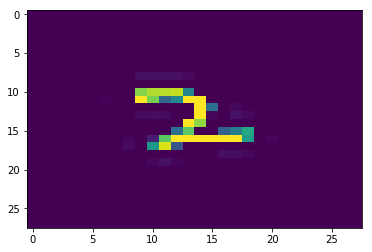

In [9]:
def imageprepare(filename):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(filename).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (0)) #creates white canvas of 28x28 pixels
    
    if width > height: #check which dimension is bigger
        #Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0/width*height),0)) #resize height according to ratio width
        if (nheight == 0): #rare case but minimum is 1 pixel
            nheight = 1
        # resize and sharpen
        img = im.resize((20,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight)/2),0)) #caculate horizontal pozition
        newImage.paste(img, (4, wtop)) #paste resized image on white canvas
    else:
        #Height is bigger. Heigth becomes 20 pixels. 
        nwidth = int(round((20.0/height*width),0)) #resize width according to ratio height
        if (nwidth == 0): #rare case but minimum is 1 pixel
            nwidth = 1
         # resize and sharpen
        img = im.resize((nwidth,20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth)/2),0)) #caculate vertical pozition
        newImage.paste(img, (wleft, 4)) #paste resized image on white canvas
    
    #newImage.save("sample.png")

    tv = list(newImage.getdata()) #get pixel values
    
    #normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [ (x)*1.0/255.0 for x in tv] 
    return tva
    #print(tva)
    
%matplotlib inline 
image_size = 28 

graph = tf.Graph() 
with graph.as_default():
    filename = "/Users/nghia/tmp/nghia/training-images/2/7_295.png"
    img = imageprepare(filename)
tt = 900
one_image = mnist.train.images[tt] 
show_image = one_image.reshape([image_size, image_size])

predict_image = np.array(img)
predict_image = predict_image.reshape([image_size, image_size])
plt.imshow(predict_image, aspect="auto") 

#show_image = numpy.flip(one_image.reshape([image_size, image_size]), 0)
#show_image = numpy.rot90(show_image, 3)
graph = tf.Graph() 

#img_input = img.reshape([1, image_size * image_size])
#img_input = one_image.reshape([1, image_size * image_size]).astype(np.float32)
#letter_map = ['I', 'K', 'R', 'i', 'k', 'r']
letter_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
#print("Label:", mnist.train.labels[tt])
#print("Label:", letter_map[np.argmax(mnist.train.labels[tt])])
#plt.imshow(show_image, aspect="auto") 
#print(show_image)

trained_filename = '/Users/nghia/rec_table/train/checkpoint/lala'
with graph.as_default():
    new_saver = tf.train.import_meta_graph(trained_filename + '.meta') 
    x = graph.get_tensor_by_name("x:0") 
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    y_conv = tf.get_collection('y_conv')[0]
    predict = tf.argmax(y_conv, 1)
with tf.Session(graph=graph) as session:
    new_saver.restore(session, trained_filename)
    v_ = session.run(predict, feed_dict = {"x:0": [img], "keep_prob:0": 1.0}) 
    #print(v_)
print("Result:", letter_map[v_[0]])
    
    




In [6]:
# Retrain from last checkpoint 

trained_filename = '/Users/nghia/rec_table/train/checkpoint/mama1'
new_trained_filename = '/Users/nghia/rec_table/train/checkpoint/mama2'
num_steps = 10

# We can now access the default graph where all our metadata has been loaded
graph = tf.Graph()
session = tf.Session(graph=graph)
print("Starting retrain...")
with graph.as_default():
    new_saver = tf.train.import_meta_graph(trained_filename + '.meta') 
    new_saver.restore(session, trained_filename)
    x = graph.get_tensor_by_name("x:0") 
    y_ = graph.get_tensor_by_name("y_:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    train_step = tf.get_collection("train_step")[0]
    accuracy = tf.get_collection('accuracy')[0]
    for i in range(num_steps):
        batch = mnist.train.next_batch(50) 
        if i % 10 == 0:
            train_accuracy = session.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))    
            
        session.run(train_step, feed_dict={'x:0': batch[0], 'y_:0': batch[1], keep_prob: 0.5})
    #print('test accuracy %g' % session.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))    
    new_saver.save(session, new_trained_filename)
    print("Done!!")
    


Starting retrain...
INFO:tensorflow:Restoring parameters from /Users/nghia/rec_table/train/checkpoint/mama1
step 0, training accuracy 1
step 1, training accuracy 1
step 2, training accuracy 1
step 3, training accuracy 1
step 4, training accuracy 1
step 5, training accuracy 1
step 6, training accuracy 1
step 7, training accuracy 1
step 8, training accuracy 1
step 9, training accuracy 1
Done!!
